Reference: 
1. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
2. https://www.tensorflow.org/tutorials/generative/dcgan     
3. https://github.com/christianversloot/machine-learning-articles/blob/main/creating-dcgan-with-tensorflow-2-and-keras.md 
4. https://towardsdatascience.com/developing-a-dcgan-model-in-tensorflow-2-0-396bc1a101b2 

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import json

from IPython import display

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
testtt = "abc"
numb = 2e-4
teststr = testtt + '_lrgen{}'.format(numb)
print(teststr)

abc_lrgen0.0002


In [4]:
# generate the seed to start the generator
num_examples = 16
dim_noise = 100
seed = tf.random.normal([num_examples,dim_noise])

In [5]:
class DCGAN_model():
    
    def __init__(self,
                batch_size=256,
                dropout=0.3,
                kernel_size=(5,5),
                lr_generator=2e-4,
                lr_discriminator=2e-4,
                beta_1_generator=0.5,
                beta_1_dicriminator=0.5,
                folder_prefix="DCGAN"):
        self.batch_size = batch_size
        # some parameters needed in the generator and discriminator
        self.dropout = dropout
        self.dense_width = 7     #the dense width of noise to first layer in generator
        self.dense_depth = 256   #the dense depth of noise to first layer in generator
        self.dense_size = self.dense_width * self.dense_width * self.dense_depth   #dense to this size in the first layer in generator
        self.kernel_size = kernel_size
        self.strides_size = 2
        self.strides = (self.strides_size, self.strides_size)

        # for ADAM optimizer
        self.lr_generator=lr_generator
        self.lr_discriminator=lr_discriminator
        self.beta_1_generator=beta_1_generator
        self.beta_1_dicriminator=beta_1_dicriminator
        beta_2=0.999
        epsilon=1e-07
        
        self.folder_name = folder_prefix + "_bs{}_dr{}_ks{}_lrg{}_lrd{}_b1g{}_b1d{}".format(batch_size,
                                                                                           dropout,
                                                                                           kernel_size,
                                                                                           lr_generator,
                                                                                           lr_discriminator,
                                                                                           beta_1_generator,
                                                                                           beta_1_dicriminator)
        
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.generator = self.init_generator()
        self.discriminator = self.init_discriminator()
        
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_generator,
                                           beta_1=beta_1_generator,
                                           beta_2=beta_2,
                                           epsilon=epsilon)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_discriminator,
                                           beta_1=beta_1_dicriminator,
                                           beta_2=beta_2,
                                           epsilon=epsilon)
        
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.batch_size, dim_noise])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real = self.discriminator(images, training=True)
            gen_out = self.discriminator(generated_images, training=True)

            gen_loss_step = self.gen_loss(gen_out)
            disc_loss_step = self.dis_loss(real, gen_out)

        grad_gen = gen_tape.gradient(gen_loss_step, self.generator.trainable_variables)
        grad_dis = disc_tape.gradient(disc_loss_step, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(grad_dis, self.discriminator.trainable_variables))
        
    def epoch_losses(self, test_dataset):
        gen_losses = []
        disc_losses = []
        for image_batch in test_dataset:
            noise = tf.random.normal([self.batch_size, dim_noise])
            generated_images = self.generator(noise, training=False)

            real = self.discriminator(image_batch, training=False)
            gen_out = self.discriminator(generated_images, training=False)

            gen_losses.append(self.gen_loss(gen_out))
            disc_losses.append(self.dis_loss(real, gen_out))
        
        return np.average(gen_losses), np.average(disc_losses)
    
    # generator loss, only one, the loss between real 0,1 out put and the noise point 
    def gen_loss(self, gen_out):
        gen_loss = self.loss(tf.ones_like(gen_out), gen_out)
        return gen_loss

    #discriminator loss, has two parts: loss of predicting fake images and real images
    def dis_loss(self, real, gen_out):
        dis_loss = self.loss(tf.ones_like(real), real) + self.loss(tf.zeros_like(gen_out), gen_out)
        return dis_loss
    
    def init_generator(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(self.dense_size, use_bias=False, input_shape=(dim_noise,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((self.dense_width, self.dense_width, self.dense_depth)))

        #first layer, 7*7*256-->14*14*128
        model.add(layers.Conv2DTranspose(self.dense_depth/2, 
                                         self.kernel_size, 
                                         strides=(1,1), 
                                         padding='same', 
                                         use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        #second layer  14*14*128-->14*14*64
        model.add(layers.Conv2DTranspose(self.dense_depth/4, 
                                         self.kernel_size, 
                                         strides=self.strides, 
                                         padding='same', 
                                         use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        #third layer  14*14*64-->28*28*1
        model.add(layers.Conv2DTranspose(1, 
                                         self.kernel_size, 
                                         strides=self.strides, 
                                         padding='same', 
                                         use_bias=False,
                                         activation='tanh'))

        return model
        
    def init_discriminator(self):
        # first convolution, from 28*28*1 to 14*14*64
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(filters=self.dense_depth/4,
                                kernel_size=self.kernel_size,
                                strides=self.strides,
                                padding='same',
                                input_shape=[self.dense_width*2*2, self.dense_width*2*2, 1]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(self.dropout))

        # second convolution, from 14*14*64 to 14*14*128
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(filters=self.dense_depth/2,
                                kernel_size=self.kernel_size,
                                strides=self.strides,
                                padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(self.dropout))

        # third convolution, from 14*14*128 to 7*7*256
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(filters=self.dense_depth,
                                kernel_size=self.kernel_size,
                                strides=self.strides,
                                padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(self.dropout))

        # from 7*7*256 to sequence to dense (1)
        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model
        
    

In [6]:
# save the images for each epoch
#reference: https://www.tensorflow.org/tutorials/generative/dcgan
def save_images(model, epoch, test_input, folder_name):
    pred = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(pred.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('{}/image_at_epoch_{:04d}.png'.format(folder_name, epoch))
    plt.show()

In [7]:
def save_plot_losses(gen_losses, real_losses, model_name, folder_name):
    # summarize history for loss
    plt.plot(gen_losses)
    plt.plot(real_losses)
    plt.title(model_name)
    plt.ylabel('losses')
    plt.xlabel('epoch')
    plt.legend(['Generated', 'Real'], loc='best')
    plt.savefig('{}/{}_losses.png'.format(folder_name, model_name))
    with open('{}/{}_losses.json'.format(folder_name, model_name), 'w') as losses_file:
        json.dump(json.dumps({'gen_losses': [float(np_float) for np_float in gen_losses],
                              'real_losses': [float(np_float) for np_float in real_losses]}), losses_file)
    
    plt.show()

In [8]:
#reference: https://www.tensorflow.org/tutorials/generative/dcgan
def train_model(model, train_dataset, test_dataset, epochs):
    path = model.folder_name
    if not os.path.exists(path):
        os.makedirs(path)
    
    generated_losses = []
    real_losses = []
    for epoch in range(epochs):
        start = time.time() #returns the time as a floating point number expressed in seconds since the epoch

        for image_batch in train_dataset:
            model.train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        save_images(model.generator,
                    epoch + 1,
                    seed,
                    model.folder_name)

        # Save the model every 20 epochs
        #if (epoch + 1) % 20 == 0:
        #    checkpoint.save(file_prefix=checkpoint_prefix)
        
        epoch_losses = model.epoch_losses(test_dataset)
        generated_losses.append(epoch_losses[0])
        real_losses.append(epoch_losses[1])
        
        print('Generated loss={}, Real loss={}'.format(epoch_losses[0], epoch_losses[1]))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('Model Name: {}'.format(model.folder_name))
    
    save_plot_losses(generated_losses, real_losses, model.folder_name, model.folder_name)

tf.Tensor([[0.00211997]], shape=(1, 1), dtype=float32)


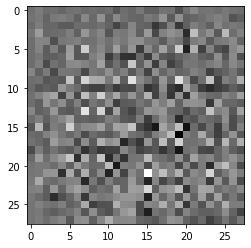

In [10]:
dcgan_model = DCGAN_model()

batch_size = 256
buffer_size = 60000

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float')

train_images = tf.keras.utils.normalize(train_images) #normalize the input data
test_images = tf.keras.utils.normalize(test_images)

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(buffer_size).batch(batch_size)

# Input the noise
noise = tf.random.normal([1, 100])
generated_image = dcgan_model.generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# input an image to tell if it is a true image
decision= dcgan_model.discriminator(generated_image)
print(decision)  #positive for true and negative for false

In [11]:
#checkpoint_dir = './training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=dcgan_model.generator_optimizer,
#                                 discriminator_optimizer=dcgan_model.discriminator_optimizer,
#                                 generator=dcgan_model.generator,
#                                 discriminator=dcgan_model.discriminator)

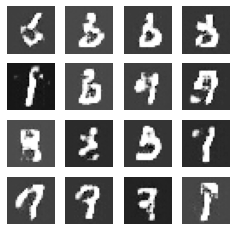

Generated loss=3.079836368560791, Real loss=0.13472828269004822
Time for epoch 50 is 12.013898372650146 sec
Model Name: DCGAN_bs256_dr0.3_ks(5, 5)_lrg0.0002_lrd0.0002_b1g0.5_b1d0.5


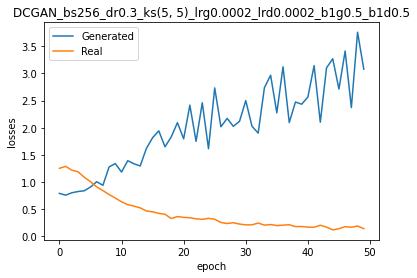

In [12]:
train_model(dcgan_model, train_dataset, test_dataset, 50)

In [160]:
batch_sizes = [64, 256, 1024]
dropouts = [0.1, 0.3, 0.5]
kernel_sizes = [(3,3), (5,5), (9,9)]
lr_generators = [5e-5, 2e-4, 8e-4]
lr_discriminators = [5e-5, 2e-4, 8e-4]
beta_1_generators = [0.3, 0.5, 0.9]
beta_1_dicriminators = [0.3, 0.5, 0.9]

buffer_size = 60000

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float')

train_images = tf.keras.utils.normalize(train_images) #normalize the input data
test_images = tf.keras.utils.normalize(test_images)

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(buffer_size).batch(batch_size)

#dcgan_model = DCGAN_model(batch_size=256,
#                          dropout=0.3,
#                          kernel_size=(5,5),
#                          lr_generator=2e-4,
#                          lr_discriminator=2e-4,
#                          beta_1_generator=0.5,
#                          beta_1_dicriminator=0.5,
#                          folder_prefix='DCGAN_MNIST_DIGITS')

KeyboardInterrupt: 

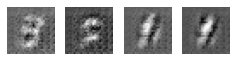

In [161]:
nb_epochs = 50
model_name = 'DCGAN_DIGITS'

for batch_size in batch_sizes:
    dcgan_model = DCGAN_model(batch_size=batch_size,
                              folder_prefix=model_name)
    train_model(dcgan_model, train_dataset, test_dataset, nb_epochs)
    
for dropout in dropouts:
    dcgan_model = DCGAN_model(dropout=dropout,
                              folder_prefix=model_name)
    train_model(dcgan_model, train_dataset, test_dataset, nb_epochs)
    
for kernel_size in kernel_sizes:
    dcgan_model = DCGAN_model(kernel_size=kernel_size,
                              folder_prefix=model_name)
    train_model(dcgan_model, train_dataset, test_dataset, nb_epochs)
    
for lr_generator in lr_generators:
    dcgan_model = DCGAN_model(lr_generator=lr_generator,
                              folder_prefix=model_name)
    train_model(dcgan_model, train_dataset, test_dataset, nb_epochs)
    
for lr_discriminator in lr_discriminators:
    dcgan_model = DCGAN_model(lr_discriminator=lr_discriminator,
                              folder_prefix=model_name)
    train_model(dcgan_model, train_dataset, test_dataset, nb_epochs)
    
for beta_1_generator in beta_1_generators:
    dcgan_model = DCGAN_model(beta_1_generator=beta_1_generator,
                              folder_prefix=model_name)
    train_model(dcgan_model, train_dataset, test_dataset, nb_epochs)
    
for beta_1_dicriminator in beta_1_dicriminators:
    dcgan_model = DCGAN_model(beta_1_dicriminator=beta_1_dicriminator,
                              folder_prefix=model_name)
    train_model(dcgan_model, train_dataset, test_dataset, nb_epochs)